In [1]:
globals().clear()
import numpy as np
import glob
import random
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier



import random

def modeling(x_train, x_test, y_train, y_test, MT_model, print_opt):
    performance_output = {}
    if MT_model == 'logistic':
        clf = LogisticRegression()
    elif MT_model == 'svm':
        clf = svm.SVC()
    elif MT_model == 'tree':
        clf = tree.DecisionTreeClassifier()
    elif MT_model == 'XGboost':
        clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_features=3, max_depth=3, random_state=0)
    elif MT_model == 'network':
        clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(16, 2), max_iter=1e5)
    elif MT_model == 'randomforest':
        clf = RandomForestClassifier(max_depth=2, random_state=0)

    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    if print_opt == 1:
        print('************************************************')
        print(MT_model)
        # print('confusion matrix', cnf_matrix)
        # print('precision score', precision_score(y_test, y_pred))
        # print('recall score', recall_score(y_test, y_pred))
        print('accuracy score', accuracy_score(y_test, y_pred))
        # print('f1 score', f1_score(y_test, y_pred))


    if MT_model == 'XGboost':
        performance_output['feature_importance'] = clf.feature_importances_
    else:
        performance_output['feature_importance'] = []

    performance_output['cnf_matrix'] = cnf_matrix
    performance_output['precision'] = precision_score(y_test, y_pred)
    performance_output['recall'] = recall_score(y_test, y_pred)
    performance_output['accuracy'] = accuracy_score(y_test, y_pred)
    performance_output['f1_score'] = f1_score(y_test, y_pred)

    auc_score = roc_auc_score(y_test, y_pred)
    # if print_opt == 1:
    #     print('auc score', auc_score)
    performance_output['auc'] = auc_score

    return performance_output



In [2]:
def ML_Performance(x_train, x_test, y_train, y_test, MT_model_pool, print_opt):
    # Model Development and Evaluation
    all_performances = []

    
    for i_m in MT_model_pool:
        if i_m == 'logistic':
            clf = LogisticRegression()
        elif i_m == 'svm':
            clf = svm.SVC()
        elif i_m == 'tree':
            clf = tree.DecisionTreeClassifier()
        elif i_m == 'XGboost':
            clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_features=3, max_depth=3, random_state=0)
        elif i_m == 'network':
            clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(16, 2), max_iter=1e5)
        elif i_m == 'randomforest':
            clf = RandomForestClassifier(max_depth=2, random_state=0)
        

        performances = modeling(x_train, x_test, y_train, y_test, i_m, print_opt)
        all_performances.append([performances['precision'], performances['recall'], performances['f1_score'], performances['accuracy'], performances['auc']])
        
        
        if i_m == 'XGboost':
            feature_importance = performances['feature_importance']

    # create plot
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6.18)
    index = np.arange(5)  # the number of used metrics
    bar_width = 0.15
    opacity = 0.8

    color_pool = ['r', 'g', 'b', 'c', 'm', 'y']
    for i in range(len(MT_model_pool)):
        rects = plt.bar(index + i * bar_width, all_performances[i], bar_width,
                         alpha=opacity,
                         color=color_pool[i],
                         label=MT_model_pool[i])

    # plt.title('Model comparison')
    plt.xticks(index + bar_width, ('precision', 'recall', 'f1_score', 'accuracy', 'auc'), fontsize=15)
    plt.yticks(np.arange(0, 1.0, 0.2), fontsize=15)
    plt.legend(fontsize=15, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.set_ylabel(ylabel='entropy', fontsize=20)
    ax.set_xlabel(xlabel='architectures', fontsize=15)
    plt.tight_layout()
    plt.savefig('comparison.pdf')
    
def calImportance(x_train, x_test, y_train, y_test, MT_model_pool, used_fields, print_opt):
    all_performances = []
    for i_m in MT_model_pool:
        if i_m == 'logistic':
            clf = LogisticRegression()
        elif i_m == 'svm':
            clf = svm.SVC()
        elif i_m == 'tree':
            clf = tree.DecisionTreeClassifier()
        elif i_m == 'XGboost':
            clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_features=3, max_depth=3, random_state=0)
        elif i_m == 'network':
            clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(16, 2), max_iter=1e5)
        elif i_m == 'randomforest':
            clf = RandomForestClassifier(max_depth=2, random_state=0)
        
            
        performances = modeling(x_train, x_test, y_train, y_test, i_m, print_opt)
        all_performances.append([performances['precision'], performances['recall'], performances['f1_score'], performances['accuracy'], performances['auc']])
        
        if i_m == 'tree':
            model = clf.fit(x_train, y_train)
            feature_importance = model.feature_importances_
        
        if i_m == 'XGboost':
            feature_importance = performances['feature_importance']
            feature_importance = feature_importance.tolist()

    # plot feature importance
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6.18)
    
    feature_importance = [i/sum(feature_importance) for i in feature_importance]
    sort_index = np.argsort(feature_importance)
    feature_importance = [feature_importance[i] for i in sort_index]
    used_fields = [used_fields[i] for i in sort_index]

    plt.bar(used_fields, feature_importance)

    plt.xlabel("fields")
    plt.ylabel('importance score')
    ax.set_xlabel(xlabel='Feature', fontsize=15)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.pdf')
    return feature_importance


************************************************
logistic
accuracy score 0.7890085167925438
************************************************
svm
accuracy score 0.848626064599068
************************************************
tree
accuracy score 0.9271251807809738
************************************************
XGboost
accuracy score 0.8630885425036157
************************************************
network
accuracy score 0.8493491884942953
************************************************
randomforest
accuracy score 0.8123091756387595
-2.970337261116947


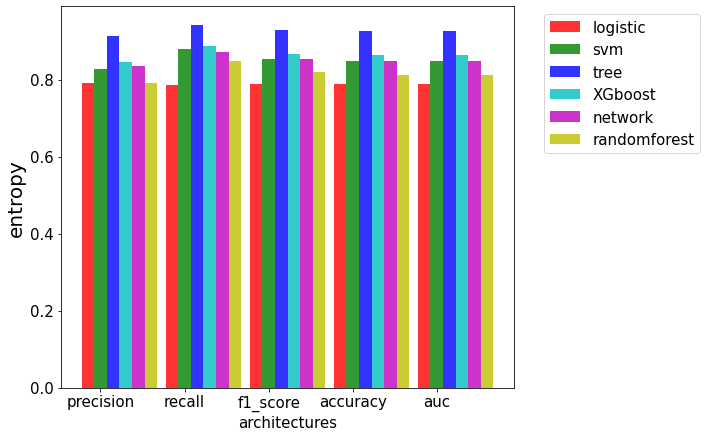

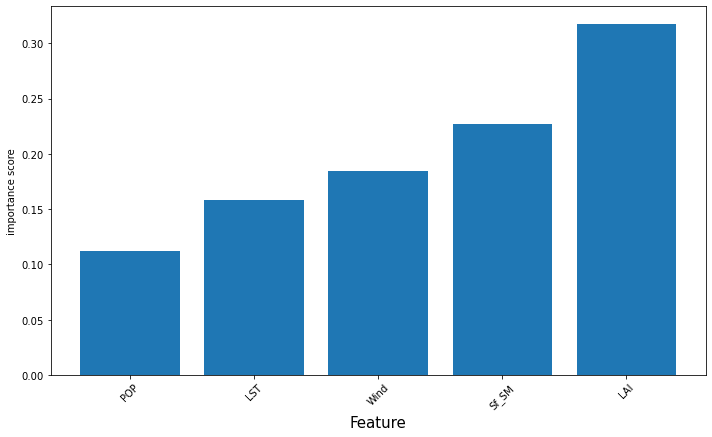

In [4]:
start = time.perf_counter()
file_months = 'predict_month_1'
data_label = 'train'
x_train = np.load('/Users/yunxiazhao/Documents/AAA_fire_pred/data/origin_2/' + file_months + '/data_' + data_label + '_x.npy')
y_train = np.load('/Users/yunxiazhao/Documents/AAA_fire_pred/data/origin_2/' + file_months + '/data_' + data_label + '_y.npy')
y_train = np.ravel(y_train)
data_label = 'val'
x_test = np.load('/Users/yunxiazhao/Documents/AAA_fire_pred/data/origin_2/' + file_months + '/data_' + data_label + '_x.npy')
y_test = np.load('/Users/yunxiazhao/Documents/AAA_fire_pred/data/origin_2/' + file_months + '/data_' + data_label + '_y.npy')
y_test = np.ravel(y_test)
used_fields = ['Precip', 'LAI', 'ET', 'PET', 'S_rad', 'L_rad', 'LE', 'SH', 'Wind', 'Sf_SM', 'Sub_SM', 'P_SM', 'POP', 'Ele', 'LST'] 
MT_model_pool = ['logistic', 'svm', 'tree', 'XGboost', 'network', 'randomforest']

print_opt = 1
ML_Performance(x_train, x_test, y_train, y_test, MT_model_pool, print_opt)
print_opt = 0
feature_importance = calImportance(x_train, x_test, y_train, y_test, MT_model_pool, used_fields, print_opt)

end = time.perf_counter()
print((start-end)/60)